In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Data preprocessing for HCMC survey dataset"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "a.buch@stud.uni-heidelberg.de"


# Feature selection done by Conditional Inference Trees 

CIT uses p-value as one-a-split criterion instead of using homogeneity. The algorithm will pick the feature with the least p-value and will start splitting from it. Then it will keep going until it no longer finds statistically significant p-value or some other criteria have met such as minimum node size or max split. 

In [2]:
import sys
import numpy as np
import pandas as pd
import pickle

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, mean_squared_error# , confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, RepeatedStratifiedKFold, RepeatedKFold, cross_val_score
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt

sys.path.insert(0, "../../")
import utils.utils_feature_selection as fs
import utils.settings as s
s.init()
seed = s.seed


pd.set_option('display.max_columns', None)
plt.figure(figsize=(20, 10))

# import warnings
# warnings.filterwarnings('ignore')

%matplotlib inline

# ruff check ./model_preprocessing/Feature_selection/utils_feature_selection.py --fix

c:\Anaconda\envs\py396_c3\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


<Figure size 2000x1000 with 0 Axes>

## Load R packages to process Conditional Random Forest in python
*Note 1: all needed R packages have to be previously loaded in R*

*Note 2: Make sure that caret package version >= 6.0-81, otherwise caret.train() throws an error*

In [3]:

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr, data
import rpy2.robjects.packages as rpackages


# get basic R packages
utils = importr('utils')
base = importr('base')
dplyr = importr('dplyr')
stats = importr("stats")

# pandas.DataFrames to R dataframes 
from rpy2.robjects import pandas2ri, Formula
pandas2ri.activate()

# print r df in html
import rpy2.ipython.html
rpy2.ipython.html.init_printing()


# get libraries for CIT processing, ctree_controls etc
#partykit = importr('partykit')
party = importr('party')
caret = importr('caret') # package version >=
#stablelearner = importr('stablelearner')
ggplot2 = importr('ggplot2')


### input data

In [4]:
df_candidates = pd.read_excel("../../input_survey_data/input_data_business.xlsx")
print(df_candidates.shape)
df_candidates.tail(2)


(397, 61)


,Target_contentloss_euro,Target_businessreduction,inundation_duration_h,water_depth_cm,contaminations.0,contaminations.1,contaminations.2,contaminations.3,contaminations.4,flowvelocity,warning_time_h,emergency_measures.1,emergency_measures.2,emergency_measures.3,emergency_measures.4,emergency_measures.6,emergency_measures.7,emergency_measures.8,emergency_measures.9,overall_problem_house,protect_valuables_impl,water_barriers_impl,pumping_equipment_impl,elevation_building_impl,resistant_material_building_impl,electricity_higher_impl,flood_protections_impl,flood_experience,elevation_building_height_cm,elevation_rel2surrounding_cat,bage,b_area,hh_monthly_income_cat,shp_owner,shp_sector,shp_employees,shp_avgmonthly_sale_cat,shp_finance_investments,shp_suppliers_location.1,shp_suppliers_location.2,shp_suppliers_location.3,shp_suppliers_location.4,shp_suppliers_location.5,shp_profits_last5years,shp_risk_tolerance,shp_monetary_resources4prevention,resilience_city_protection,resilience_more_future_affected,resilience_govern_warnings_helpful,resilience_govern_careing,resilience_govern_careing_increases,resilience_left_alone,resilience_neighbor_management,perception_who_responsible4protection.Rank1,perception_who_responsible4protection.Rank2,perception_govern_support_past,perception_govern_support_future,perception_private_economy_future,shp_content_value_euro,shp_registered_capital_euro,elevation_m
395,0.0,NaN,4.0,70.0,0,1,0,0,1,1,NaN,1,0,1,0,1,0,0,0,1,1,5,1,1,5,5,5,5,70.0,1,NaN,130.0,NaN,1,17,2,3,1,1,1,0,0,0,4.0,3.0,3.0,1.0,5.0,1.0,1.0,1.0,5,1.0,2.0,2.0,NaN,1.0,3.0,NaN,11047.7,1.83886
396,0.0,0.0,3.0,100.0,0,1,0,0,1,1,NaN,1,0,1,0,0,0,0,0,0,1,5,5,5,5,5,5,4,NaN,0,5.0,33.0,1.0,1,11,2,3,1,1,1,0,0,0,4.0,3.0,4.0,NaN,NaN,NaN,NaN,NaN,5,NaN,3.0,2.0,NaN,NaN,3.0,NaN,736.5,1.87277


In [5]:
targets = ["Target_contentloss_euro", "Target_businessreduction"]
target = targets[0]

## TODO make entire wokflow as loop over both target variables
# ## iterate over both targets and store results 
# for target in ["Target_contentloss_euro", "Target_businessreduction"]:

#     print( f"Apply Elastic Net on {target}:\n")
#     y = df_candidates[target]


## remove cases where target information is missing
df_candidates = df_candidates[ ~df_candidates[f"{target}"].isna()]
print(df_candidates.shape)

X = df_candidates.drop(targets, axis=1)
y = df_candidates[target]


## TEST: replace nan with median of each variable
for c in X.columns:
    X[c].fillna(X[c].median(), inplace=True)

(386, 61)


#### Split Data

In [6]:
## test train split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, 
    random_state=seed, shuffle=True
)

# normlaize via MinMaxScaler, transform X_train ,then use the fitted scaler for X_test
X_train, X_test = fs.normalize_X(X_train, X_test)

train = pd.concat([y_train.reset_index(), X_train], axis=1).drop("index", axis=1)
test = pd.concat([y_test.reset_index(), X_test], axis=1).drop("index", axis=1)

### Model fit

In [7]:
# from rpy2.robjects.conversion import localconverter

# # Convert a Pandas DataFrame to an R DataFrame
# def pandas_to_r_dataframe(df):
#     with localconverter(robjects.default_converter + pandas2ri.converter):
#         r_dataframe = robjects.conversion.py2rpy(df)
#     return r_dataframe

# # Convert the Pandas DataFrame to an R DataFrame
# data_train_r = pandas_to_r_dataframe(train)
# x_train_r = pandas_to_r_dataframe(X_train)
# x_test_r = pandas_to_r_dataframe(X_test)
# y_train_r = pandas_to_r_dataframe(y_train)

# # Convert Pandas DataFrame to R list
# y_train_l = robjects.r.list(**dict(zip(y_train_r.names, y_train_r)))
# column_names = " + ".join(X_train.columns)
# #formula = robjects.Formula(f'{target} ~ ' + column_names)

In [8]:
data_train_r#.info()
randomForest = importr("randomForest")
#train.isnull().sum()

NameError: name 'data_train_r' is not defined

In [35]:
##  CV with gridSearch from R 
## Due that cforest is a R package it only accepts other R functions for tunning and cross validation  

## Define the hyperparamters
params_grid = base.expand_grid(
    mtry=3,
    #ntree=[10, 50 ,100 , 200],  
    #method = 'cforest'
    mincriterion = [0, 0.2, 0.4, 0.6, 0.8],   ## Minciterion = confidence level (smaller values => larger trees; e.g mincriterion=0.8, p-value must be smaller than 0.2 in order for a node to split)
    #seeds=seed
    #maxdepth = [0, 2, 5, 7]
    )

## Define hyperparameters
# params = party.cforest_control(mtry=3, ntree=100,  seeds=seed,   mincriterion = 0.8)

# prepare the model 
# model = { 'estimator': party.cforest(Formula(f'{target} ~ .'), data=train),
#         'parameters': params_grid
#     }
# pipeline = Pipeline(steps=[model['estimator']])
#pipeline = Pipeline(steps=[('model', party.cforest(Formula(f'{target} ~ .'), data=train) ) ])

# Tune hyper parameters by setting tuneGrid
#base.set_seed(seed)
fitControl = caret.trainControl(
    method = "repeatedcv",
    number = 10,   ## = K-folds
    repeats = 3
    )
#createCfGrid = base.expand_grid(controls = party.cforest_control(mtry=3, ntree=200)) #qnorm() =90th percentile
# mincriterion=stats.qnorm(0.9)

# g = caret.createGrid(method="cforest", len=5, data=train)  # tunning Grid
# len = an integer specifying the number of points on the grid for each tuning parameter.
# data = training data
# print(g)
# will generate that for you. If you want to specify ntree you just pass a controls object in as another argument to train but leave out mtry:
mod = caret.train(
        Formula(f'{target} ~ .'), 
        data = train,
        method = "cforest",
        controls = party.cforest_unbiased(mtry= 3, ntree = 100),  # cforest_unbiased= subsampling without replacement
        trControl = fitControl,
        #tuneGrid = params_grid,
        verbose = True
    )
## TODO cant use gridsearch for hyperparamter tunning, but at lest CV works
    
## wokrs if controls has cforet_() + trControl
## not          tuneGrid = createCfGrid or params_grid


R[write to console]: Error: The tuning parameter grid should have columns mtry



RRuntimeError: Error: The tuning parameter grid should have columns mtry


In [ ]:

crf_cv = caret.train( 
    Formula(f'{target} ~ .'), 
    #x = "inundation_duration_h", y= f"{target}",
    data = train, #Formula(f'{target} ~ .'), data = train, 
    method = "cforest", 
    metric='Rsquared',#Rsquared',   ## RMSE, MAE test neg. mse
    na_action =  stats.na_pass, # na.pass= will pass the NA values unmodified directly to the prediction function
    #na_action =  randomForest.na_roughfix, # na.omit:  leads to rejection of cases with missing values on any required variable
    tuneGrid = params_grid, 
    ntree=1000,
    trControl = fitControl   # party.cforest_control(mtry=3, ntree=1000) #  define CV
    )
## train() Doc: https://search.r-project.org/CRAN/refmans/caret/html/train.html

warnings()

In [ ]:

## Parameters of best model
#print(crf_cv.bestTune)

## RandomizedCV to find best hyperparameters
#cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=seed)  # =kfold=10, # cv method TODO find better method maybe RepeatedStratifiedKFold
#crf_cv = RandomizedSearchCV(
#    pipeline, param_distributions=model['parameters'], 
#    cv=cv, scoring="neg_mean_absolute_error", random_state=seed
#    )


# ## CIT handles by default missing values in response, while CRF doesnt acept missing vlaues in response
# #cit_model = partykit.ctree(Formula(f'{target} ~ .'),  
#crf_model = party.cforest(Formula(f'{target} ~ .'),  
#                                data=train,
#                                 control=party.cforest_control(mtry=3, ntree=1000))
#                                 #control = partykit.ctree_control(mincriterion = 0.8)
#                                 # TODO fix hyper.tunning:  control=params
#      

In [ ]:
control=params,#party.cforest_control(mtry=3, ntree=1000)

In [14]:
# ## specify model
# cit_model = partykit.ctree(Formula('Target_contentloss_euro ~ .'),  
#                                 data=train

## Minciterion = confidence level (smaller values => larger trees; e.g mincriterion=0.8, p-value must be smaller than 0.2 in order for a node to split)
# params = party.cforest_control(mtry=3, ntree=100,  
#     mincriterion = 0.8)

# # prepare the model 
# model = { 'estimator': party.cforest(Formula(f'{target} ~ .'), data=train),
#         'parameters': params
#     }
# pipeline = Pipeline(steps=[model['estimator']])


## fit model
# ## CIT handles by default missing values in response, while CRF doesnt acept missing vlaues in response
# #cit_model = partykit.ctree(Formula(f'{target} ~ .'),  
# crf_model = party.cforest(Formula(f'{target} ~ .'),  
#                                 data=train,
#                                 control=params,#party.cforest_control(mtry=3, ntree=1000)
#                                 #control = partykit.ctree_control(mincriterion = 0.8)
#                                 # TODO fix hyper.tunning:  control=params
#                           )


# ## store trained model for evaluation
# filename = f'./models_trained/crf_{target}'
# pickle.dump(crf_model, open(filename, 'wb'))

print(crf_cv)

RandomizedSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=42),
                   estimator=Pipeline(steps=[<rpy2.robjects.methods.RS4 object at 0x0000026813436840> [RTYPES.S4SXP]
R classes: ('RandomForest',)]),
                   param_distributions=<rpy2.robjects.methods.RS4 object at 0x000002687BF29B80> [RTYPES.S4SXP]
R classes: ('ForestControl',),
                   random_state=42, scoring='neg_mean_absolute_error')


In [33]:
## Snippet from: https://cran.r-project.org/web/packages/stablelearner/vignettes/forests.html
# cf_stablelearner = stablelearner.stabletree(cit_model,
#   sampler = stablelearner.subsampling, savetrees = True, B = 100, v = 0.632)
# #Internally, stablelearner::stabletree() does the following: For each of the 100 trees to be generated, the dataset is resampled according to the resampling method specified (in our case subsampling with a fraction of v = 0.632) and the function call of our initial tree (which we labeled ct_partykit) is updated with respect to this resampled data and reevaluated, resulting in a new tree. All the 100 trees together then build the forest.

# #2.2 Gaining insight into the forest
# #The following summary prints the variable selection frequency (freq) as well as the average number of splits in each variable (mean) over all 100 trees. As we do not want to focus on our initial tree (remember that we just grew a forest, where all trees are of equal interest), we set original = FALSE, as already mentioned in the introduction:
# t = base.summary(cf_stablelearner, original = False)

# ## Variable selection overview:
# ## Note: n python we can see the R df.index which contains the variable names, therefore it is not very usefull
# #pd.DataFrame(t).iloc[3,:][0] # frequency
# #pd.DataFrame(t).iloc[3,:][1] # mean
# #print(X.columns[:23])

## Feature selection

In [38]:
# ## actual p-values (without log)
# strucchange = importr("strucchange")
# strucchange.sctest(cit_model, node = 1)[1]  # p values

In [91]:
## Code snippet from Danielas CRF script and from https://cran.r-project.org/web/packages/stablelearner/vignettes/forests.html

## Calculate variance importance based on selection frequency
# varimp = party.varimp(model, measures=["freq"])
# varimp_df = pd.DataFrame({'Variable': varimp.names, 'Importance': varimp})
## Sort the variable importance in descending order
# varimp_df = varimp_df.sort_values(by='freq', ascending=False)
## Plot the variance importance
# varimp_df.plot(kind='bar', x='term', y='freq', figsize=(10, 6))

# Extract variable importance values from the model
varimp = party.varimp(crf_cv)
# t = caret.varImp(crf_model)#, conditional=True) # caret derives FI a bit differently than part package
# pd.DataFrame({"names":X.columns.to_list(), "importances":pd.Series(t)[0]}).sort_values("importances", ascending=False).head(5)

NotImplementedError: Conversion 'py2rpy' not defined for objects of type '<class 'sklearn.model_selection._search.RandomizedSearchCV'>'

In [84]:
## select significant features by using elstic net coefs (= linear relationship between features ~ target, adjusted by the regularization terms)
df_importance = pd.DataFrame({
    "importances" : varimp, 
    }, index= X.columns.to_list())
#df_importance = df_importance.loc[df_importance.importances > importances_threshold[target], : ].T      # drop features which dont reduce the loss

## TODO check if abs value of negative importances from CRF should be used
df_importance = df_importance.sort_values("importances", ascending=False)
df_importance.head(5)

,importances
perception_who_responsible4protection.Rank1,2.415815e+06
b_area,2.393333e+06
shp_suppliers_location.4,1.507146e+06
shp_employees,1.338384e+06
emergency_measures.9,8.923117e+05


#### Feature importance

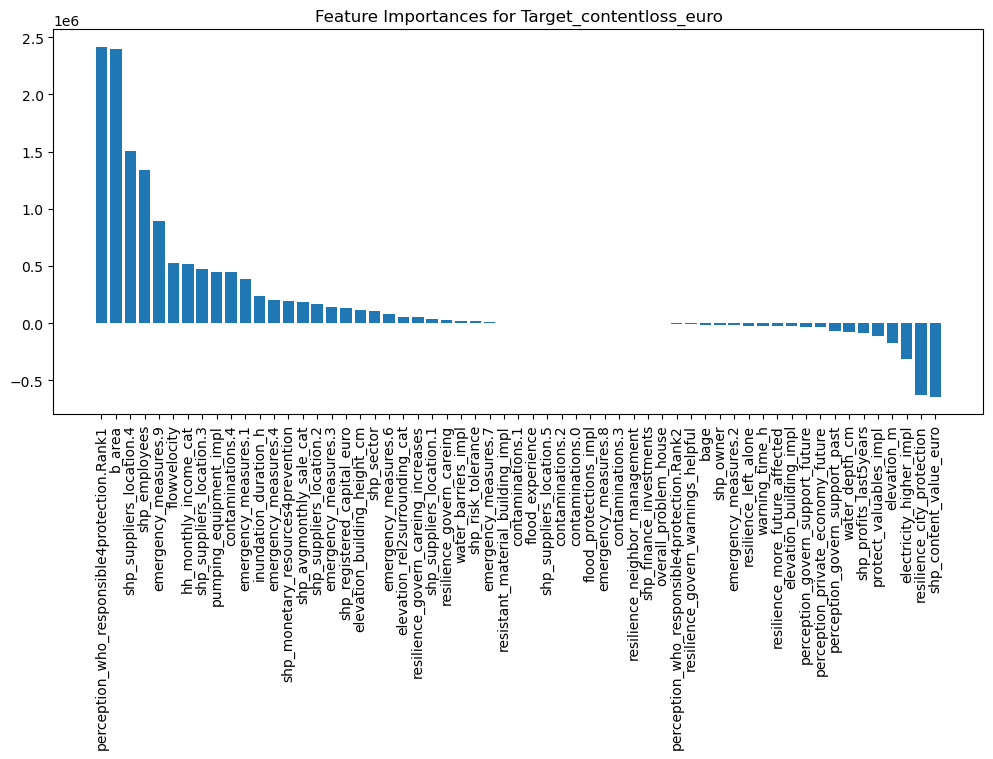

In [85]:
# plot feature importance
fig, ax = plt.subplots(figsize=(12,5))


# keep only features which reduce the loss
#df_importance = df_importance.loc[df_importance.importances > 0, : ]

plt.bar(df_importance.index, df_importance.importances)
plt.xticks(
    #ticks = range(len(selected_feat)),
    #labels = X_unscaled.iloc[:,selected_feat],
    rotation = 90
    )
plt.title(f"Feature Importances for {target}")

plt.show()

In [ ]:
y_train.shape

(289,)

In [ ]:
## Predict
y_pred = stats.predict(cit_model, test, type="response") #  type = "prob" # conditional class probabilities
y_pred  = base.round(y_pred)

## get back to python dtypes
y_pred = np.array(y_pred)
y_test = np.array(y_test)
y_test = np.array(y_test)
y_test = np.array(y_test)


## TODO find good evaluation metrics eg R2 for training set 
## --> test via GridSearchCV and RepeatedKFold or RStatifiedKFold
#r2 = np.corrcoef(X_train,y_train)**2 
#print(f"Training set score (R^2): {r2}")
#rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#print("RMSE:  {:.2f}".format(rmse)) 
#np.mean((y_test - cit_pred)**2)


## Model evaluation

In [ ]:
cit_model_p = pickle.load(open(f"./models_trained/cit_{target}", 'rb'))
type(cit_model_p)
#cit_model_p.__dir__()

rpy2.robjects.vectors.ListVector

#### Statistics related to CIT and CRF

The log rather than the p-value is used because it is numerically much more stable when used for comparisons, computing the minimal value, etc. Note that the p-values can become extremely small when significant. 


statistic DEF: 

citrerion DEF: 



In [141]:
## get signifcant features
selected_feat = cit_stats.loc[:, cit_stats.loc["p_value",:]<= 0.05]

## write selected predictors to disk
fs.save_selected_features(X_train, pd.DataFrame(y_train), selected_feat.columns, filename=f"../../input_survey_data/fs_cit_{target}.xlsx")


selected features: 10
dropped features: 49
selected features: 
['b_area', 'hh_monthly_income_cat', 'shp_sector', 'shp_employees', 'shp_avgmonthly_sale_cat', 'shp_suppliers_location.3', 'shp_suppliers_location.4', 'perception_who_responsible4protection.Rank1', 'shp_content_value_euro', 'shp_registered_capital_euro']

Saving model to disk: ../../input_survey_data/fs_cit_Target_contentloss_euro.xlsx


In [64]:
cit_model_p.rx(3)

R[write to console]: Error in character_split(split_node(x), data = data, digits = digits,  : 
  unused argument (useS4 = FALSE)



0,3,[1]...
1,4,...
2,5,...
3,6,Target_co...
4,7,['3' '4'...
5,8,$call (fu...


In [50]:
cit_model_p.names
cit_model_p = np.array(cit_model_p.rx(3))
cit_model_p

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (6,) + inhomogeneous part.

In [163]:
# define the model evaluation by k-fold CV
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(cit_model_p, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

InvalidParameterError: The 'estimator' parameter of check_scoring must be an object implementing 'fit'. Got <rpy2.robjects.vectors.ListVector object at 0x00000282FCAEBDC0> [RTYPES.VECSXP]
R classes: ('constparty', 'party')
[Lis..., Lis..., Lis..., Lan..., NUL..., Lis..., Sex..., Sex...]
  1: <class 'rpy2.rinterface.ListSexpVector'>
  <rpy2.rinterface.ListSexpVector object at 0x00000282DF5FD0C0> [RTYPES.VECSXP]
  2: <class 'rpy2.rinterface.ListSexpVector'>
  <rpy2.rinterface.ListSexpVector object at 0x00000282DF5FA0C0> [RTYPES.VECSXP]
  3: <class 'rpy2.rinterface.ListSexpVector'>
  <rpy2.rinterface.ListSexpVector object at 0x00000282DF5FD0C0> [RTYPES.VECSXP]
  4: <class 'rpy2.rinterface.LangSexpVector'>
  <rpy2.rinterface.LangSexpVector object at 0x00000282DF5FA0C0> [RTYPES.LANGSXP]
  5: <class 'rpy2.rinterface_lib.sexp.NULLType'>
  <rpy2.rinterface_lib.sexp.NULLType object at 0x00000282DEFB6780> [RTYPES.NILSXP]
  6: <class 'rpy2.rinterface.ListSexpVector'>
  <rpy2.rinterface.ListSexpVector object at 0x00000282DF5FA0C0> [RTYPES.VECSXP]
  7: <class 'rpy2.rinterface.SexpClosure'>
  <rpy2.rinterface.SexpClosure object at 0x00000282DF5FD0C0> [RTYPES.CLOSXP]
  8: <class 'rpy2.rinterface.SexpClosure'>
  <rpy2.rinterface.SexpClosure object at 0x00000282F202A5C0> [RTYPES.CLOSXP] instead.

In [ ]:
# compare r2 for train and test sets (for all polynomial fits)
print("R-squared values: \n")

for i, degree in enumerate(degrees):
    train_r2 = round(sklearn.metrics.r2_score(y_train, y_train_pred[:, i]), 2)
    test_r2 = round(sklearn.metrics.r2_score(y_test, y_test_pred[:, i]), 2)
    print("Polynomial degree {0}: train score={1}, test score={2}".format(degree, 
                                                                         train_r2, 
                                                                         test_r2))

(265,)